In [1]:
#import libs
import sys,os
import numpy as np

os.chdir(r'../..')
from ricepaper.material import NodeSet
from ricepaper import RicePaper
from ricepaper.utils import *

In [2]:
#define a material properties
E = [5e9,5e9, #young's modulus of strong layer
     1e9,1e9, #young's modulus of weak layer
    1e9]

v  = [0.25,0.25, #poisson ratio of strong layer
      0.15,0.15, #poisson ratio of weak layer
      0.15] #poisson ratio of boundary

UTS = [1e6,1e6, #tensile strenght of strong layer
       0.5e6,0.5e6,   #tensile strenght of weak layer
       0] #tensile strength of bonds with boundary nodes (0 = no bonding)

USS = [1e6,1e6, #shear strength of strong layer
       0.5e6, 0.5e6, #shear strenght of weak layer
       0 ] #shear strength of bonds with boundary nodes (0 = no bonding)

#construct material
mat = NodeSet("SlopeStability",[15,7.5,15,7.5,15], #radii
                         2500, #densities (applied to all radii)
                         E, v) #elastic properties 

mat.setFriction(0.1) #friction coefficient (apply the same for all particles)

#build bond stiffness and strength matrices
nStiff = np.zeros([len(E),len(E)])
sStiff = np.zeros([len(E),len(E)])
TS = np.zeros([len(E),len(E)])
SS = np.zeros([len(E),len(E)])
for m1 in range(len(E)):
    for m2 in range(len(E)):
        nStiff[m1,m2] = np.mean([E[m1],E[m2]]) #average of particle stiffnesses
        sStiff[m1,m2] = calcShearModulus(nStiff[m1,m2],np.mean([v[m1],v[m2]])) #calc from average stiffness and poisson ratio
        TS[m1,m2] = min(UTS[m1],UTS[m2]) #use tensile strength of weakest particle
        SS[m1,m2] = min(USS[m1],USS[m2]) #use shear strenght of weakest particle

mat.setBonding( nStiff,sStiff,TS,SS) #define bonding properties

In [3]:
#generate pile
freq = [[0,0,1,1,0], #frequency of nodes in lower layer
        [1,1,0,0,0], #frequency of nodes in upper layer
        [1,1,0,0,0]] #frequency of nodes in upper (again)

R = mat.gravityDeposit(500,1500,base=3000, #dimension of model
                       frequency = freq, #frequency of nodes
                       nlayers = 3, #generate 2 layers
                       walltype= 5, #particle type of walls
                       stepSize=200, #time (seconds) between checking stability
                       suppress=False)

Generating 509 particles in layer 0
Generating 509 particles in layer 1
Generating 509 particles in layer 2
'SlopeStability/gravity_pile' finished in 0.44 minutes.
Average kinetic energy = 1.392406E+08
'SlopeStability/gravity_pile' finished in 0.84 minutes.
Average kinetic energy = 3.022119E+07
'SlopeStability/gravity_pile' finished in 0.96 minutes.
Average kinetic energy = 5.718851E+06
'SlopeStability/gravity_pile' finished in 0.96 minutes.
Average kinetic energy = 1.401022E+06
'SlopeStability/gravity_pile' finished in 0.95 minutes.
Average kinetic energy = 3.013053E+05
'SlopeStability/gravity_pile' finished in 0.96 minutes.
Average kinetic energy = 3.373404E+05
'SlopeStability/gravity_pile' finished in 0.95 minutes.
Average kinetic energy = 7.652974E+04
'SlopeStability/gravity_pile' finished in 0.99 minutes.
Average kinetic energy = 4.449338E+02
'SlopeStability/gravity_pile' finished in 0.98 minutes.
Average kinetic energy = 3.749625E+01
'SlopeStability/gravity_pile' finished in 0.96

/home/user1/Documents/notebooks/riceball/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


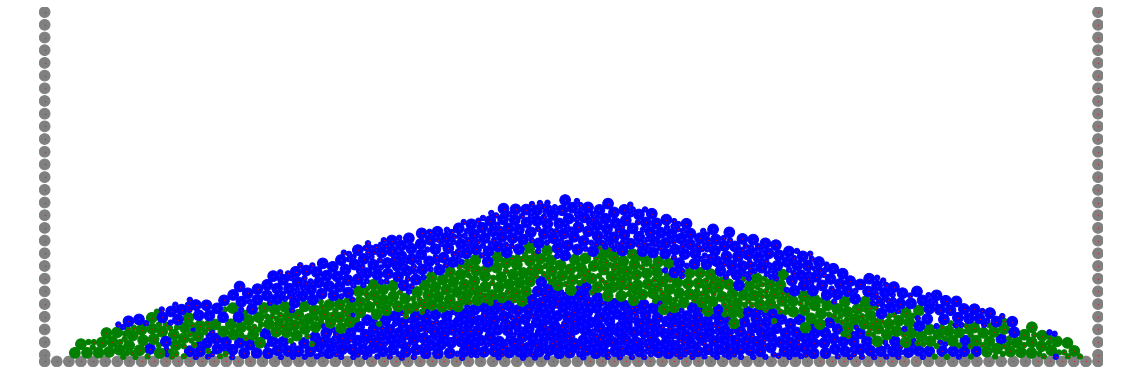

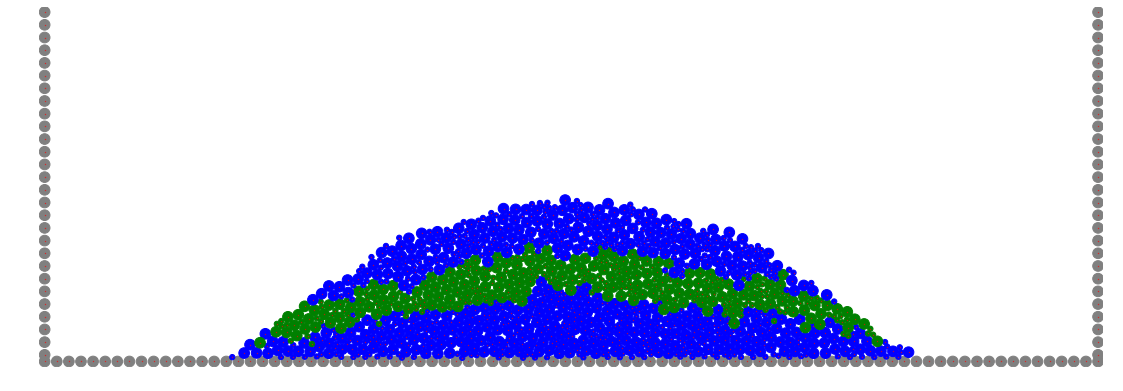

In [4]:
#shape pile
slope = 35 #slope of sculpted pile
height = 500 #height of sculpted pile
xmin = 1200 - height / np.tan( np.deg2rad(slope) )
xmax = 1800 + height / np.tan( np.deg2rad(slope) )

pile = R.loadLastOutput()
#pile = R.loadSteps([7])
pile.quickPlot() #prior to sculpting

deleted = pile.cut(xmin,slope)
deleted += pile.cut(xmax,-slope)
pile.quickPlot() #after sculpting

In [5]:
#apply sculpting
R.delBalls(deleted,pile.pos)

#bond particles
mat.bond()

#cycle for 10 x 5 second timesteps
steps = []
for i in range(10):
    steps.append(R.cycle(10))

success = R.execute(suppress = False)

'SlopeStability/gravity_pile' finished in 0.39 minutes.


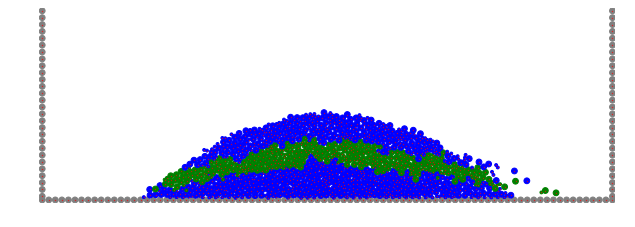

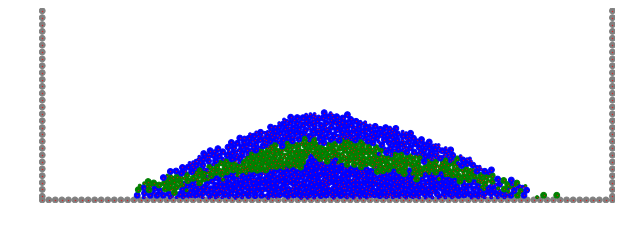

In [6]:
M = R.loadSteps(steps)
M[0].quickPlot(figsize=(8,5))
M[-1].quickPlot(figsize=(8,5))

/home/user1/Documents/notebooks/riceball/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


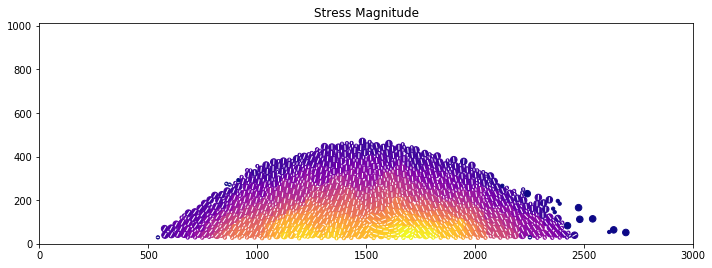

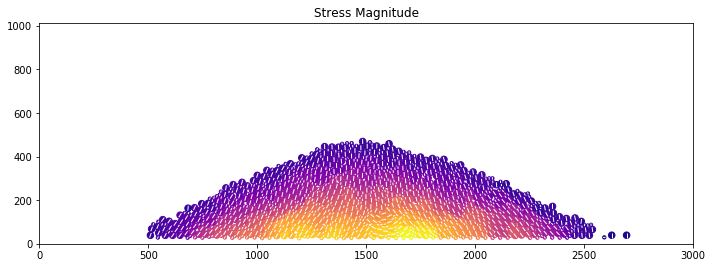

In [7]:
#plot initial and final stresses
M[0].averageAttr("stress", n = 5)
M[-1].averageAttr("stress", n = 5)

fig,ax=M[0].plotAttr("stress", func="mag", title="Stress Magnitude")
fig,ax=M[-1].plotAttr("stress", func="mag", title="Stress Magnitude")

/home/user1/Documents/notebooks/riceball/ricepaper/reader.py:959: RuntimeWarning: invalid value encountered in true_divide
  ticks.append( v2d / np.linalg.norm(v2d) ) #store normalised tick


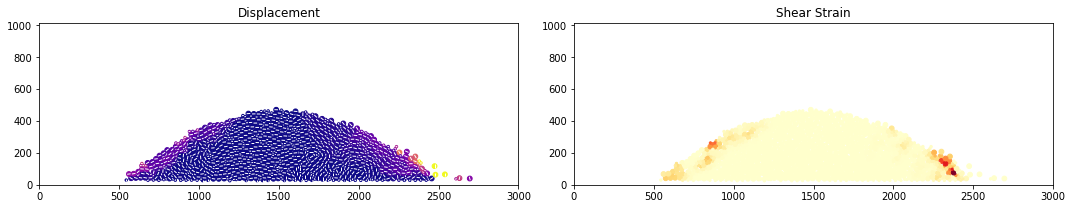

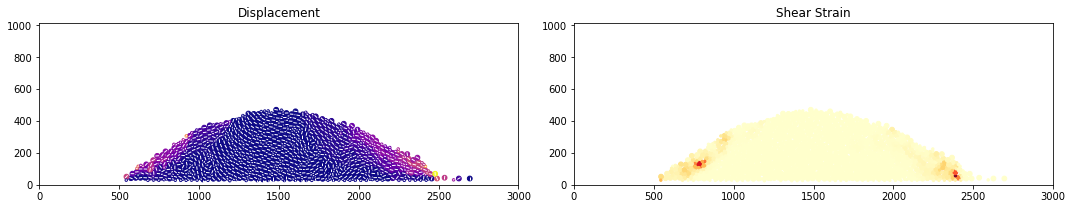

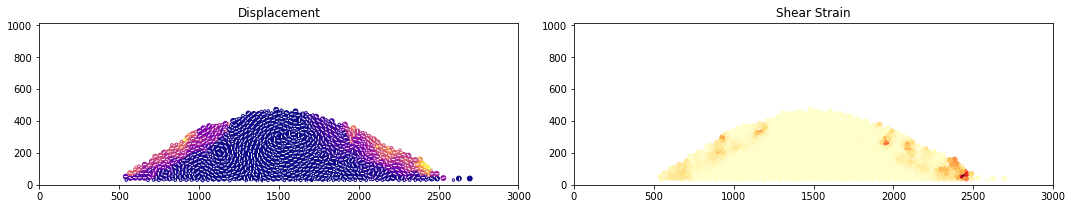

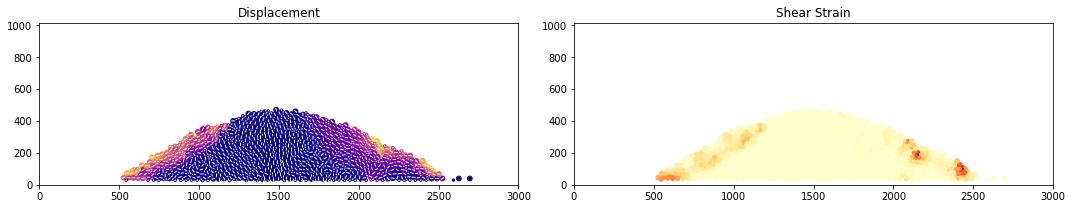

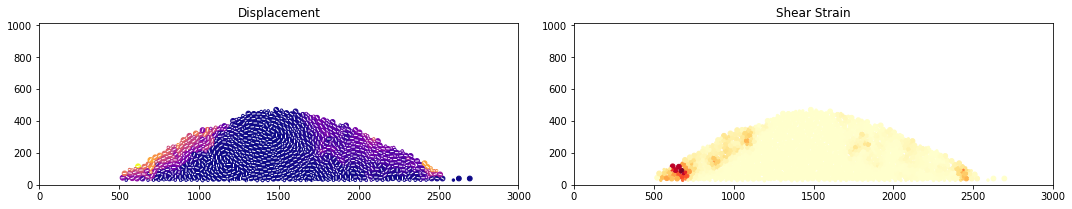

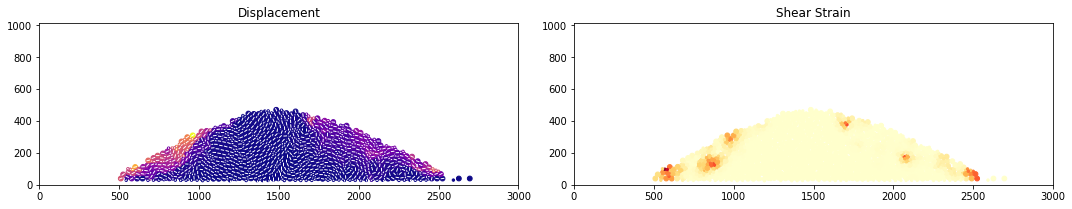

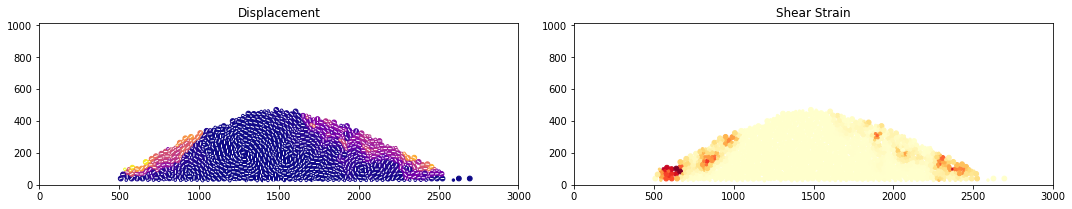

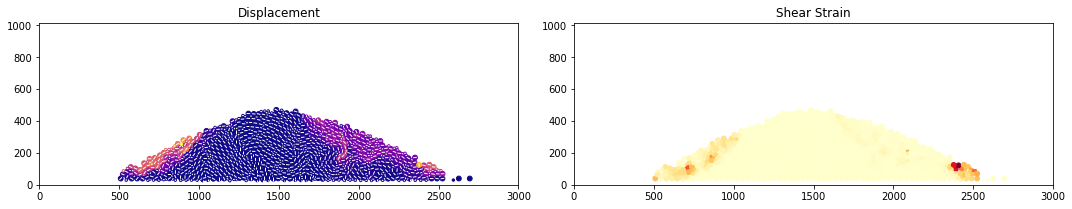

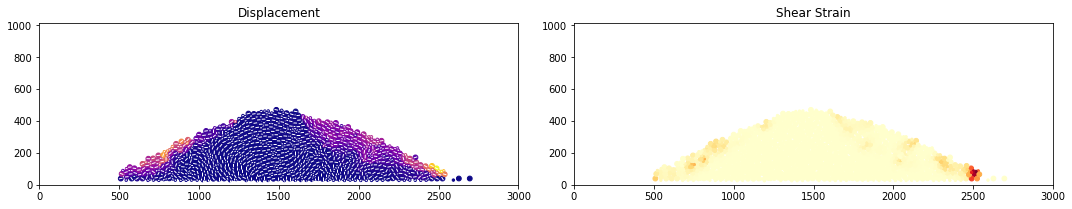

In [8]:
#compute strains and displacements and plot
for t in range(1,len(M)):
    
    #compute
    M[t].computeParticleDisplacements(M[t-1])
    M[t].computeStrain2D(M[t-1])
    
    #average strain
    M[t].averageAttr("strain",n=2,weighted=False)
    M[t].averageAttr("deviatoric_strain",n=2,weighted=False)
    
    #plot
    fig,ax = M[t].plotAttr(attr=["disp","deviatoric_strain"],func="inv2",
                           title=["Displacement","Shear Strain"],
                           linewidth = [1,0],
                           cmap = ['plasma','YlOrRd'],
                           log = [False,True],
                           figsize=(15,10))

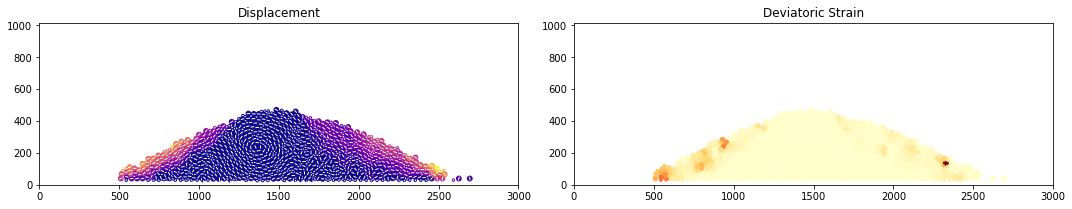

In [9]:
#and over the whole range
M[-1].computeParticleDisplacements(M[0])
M[-1].computeStrain2D(M[0])

#average strain
M[-1].averageAttr("strain",n=2)
M[-1].averageAttr("deviatoric_strain",n=2)

#plot
fig,ax = M[-1].plotAttr(attr=["disp","deviatoric_strain"],func="inv2",
                       title=["Displacement","Deviatoric Strain"],
                       linewidth = [1,0],
                       cmap = ['plasma','YlOrRd'],
                       figsize=(15,10))
